In [1]:
import json
import os
from pathlib import Path
from os.path import isfile, join
import pickle
import random
import pandas as pd
from tqdm import tqdm
import numpy as np
import dgl
from sklearn.metrics import f1_score, roc_auc_score

from typing import Optional, Union

import torch 
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data, HeteroData
from torch_geometric.transforms import RandomLinkSplit
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
from torch.nn.modules.loss import _Loss
from torch_geometric.typing import Adj, OptTensor, SparseTensor

In [2]:
seed = 12345
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
"""
Here we define classes for the data that we are going to load. The data is stored in JSON files, each
which contain playlists, which themselves contain tracks. Thus, we define three classes: 
  Track       --> contains information for a specific track (its id, name, etc.)
  Playlist    --> contains information for a specific playlist (its id, name, etc. as well as a list of Tracks)
  JSONFile    --> contains the loaded json file and stores a dictionary of all of the Playlists 
  Artists     --> contains information on the artist for a specific track(its id, name, etc.)

"""
class Artist:
  
  def __init__(self, track_dict, playlist):
    self.uri = track_dict["artist_uri"]
    self.name = track_dict["artist_name"]
    self.track_uri = track_dict["track_uri"]
    self.track_name = track_dict["track_name"]
    self.playlist = playlist

    def __str__(self):
      return f"Artist {self.uri} called {self.name} composed {self.track_uri} ({self.track_name}) in playlist {self.playlist}."
    
    def __repr__(self):
      return f"Artist {self.uri}"
      
class Track: 
  """ 
  Simple class for a track, containing its attributes: 
    1. URI (a unique id)
    2. Name
    3. Artist info (URI and name)
    4. Parent playlist
  """
  
  def __init__(self, track_dict, playlist):
    self.uri = track_dict["track_uri"]
    self.name = track_dict["track_name"]
    self.artist_uri = track_dict["artist_uri"]
    self.artist_name = track_dict["artist_name"]
    self.playlist = playlist
  
  def __str__(self):
    return f"Track {self.uri} called {self.name} by {self.artist_uri} ({self.artist_name}) in playlist {self.playlist}."
  
  def __repr__(self):
    return f"Track {self.uri}"

class Playlist: 
  """ 
  Simple class for a playlist, containing its attributes: 
    1. Name (playlist and its associated index)
    2. Title (playlist title in the Spotify dataset)
    3. Loaded dictionary from the raw json for the playlist
    4. Dictionary of tracks (track_uri : Track), populated by .load_tracks()
    5. List of artists uris
  """

  def __init__(self, json_data, index):

    self.name = f"playlist_{index}"
    self.title = json_data["name"]
    self.data = json_data

    self.tracks = {}
    self.artists = {}
  
  def load_tracks(self):
    """ Call this function to load all of the tracks in the json data for the playlist."""

    tracks_list = self.data["tracks"]
    self.tracks = {x["track_uri"] : Track(x, self.name) for x in tracks_list}
    self.artists = {x["artist_uri"] : Artist(x,self.name) for x in tracks_list}

  def __str__(self):
    return f"Playlist {self.name} with {len(self.tracks)} tracks loaded."
  
  def __repr__(self):
    return f"Playlist {self.name}"

class JSONFile: 
  """ 
  Simple class for a JSON file, containing its attributes: 
    1. File Name 
    2. Index to begin numbering playlists at 
    3. Loaded dictionary from the raw json for the full file
    4. Dictionary of playlists (name : Playlist), populated by .process_file()
  """

  def __init__(self, data_path, file_name, start_index):

    self.file_name = file_name 
    self.start_index = start_index

    with open(join(data_path, file_name)) as json_file:
      json_data = json.load(json_file)
    self.data = json_data 

    self.playlists = {}

  def process_file(self):
    """ Call this function to load all of the playlists in the json data."""

    for i, playlist_json in enumerate(self.data["playlists"]):
      playlist = Playlist(playlist_json, self.start_index + i)
      playlist.load_tracks()
      self.playlists[playlist.name] = playlist

  def __str__(self):
    return f"JSON {self.file_name} has {len(self.playlists)} playlists loaded."
  
  def __repr__(self):
    return self.file_name


In [6]:
DATA_PATH = Path('/home/kganapa/projects/Spotify_playlists_101')
N_FILES_TO_USE = 30

file_names = sorted(os.listdir(DATA_PATH))
file_names_to_use = file_names[:N_FILES_TO_USE]

n_playlists = 0 

# load each json file, and store it in a list of files
JSONs = []
for file_name in tqdm(file_names_to_use, desc='Files processed: ', unit='files', total=len(file_names_to_use)):
  json_file = JSONFile(DATA_PATH, file_name, n_playlists)
  json_file.process_file()
  n_playlists += len(json_file.playlists)
  JSONs.append(json_file)

Files processed: 100%|██████████| 30/30 [00:05<00:00,  5.90files/s]


In [7]:
playlist_data = {}
playlists = []
tracks = []
artists = []

# build list of playlists, tracks, artists
for json_file in tqdm(JSONs): 
  playlists += [p.name for p in json_file.playlists.values()]
  tracks += [track.uri for playlist in json_file.playlists.values() for track in list(playlist.tracks.values())]
  artists += [artist.uri for playlist in json_file.playlists.values() for artist in list(playlist.artists.values())]
  playlist_data = playlist_data | json_file.playlists

100%|██████████| 30/30 [00:00<00:00, 140.68it/s]


In [8]:
# build unique list of tracks , artists
tracks = list(set(tracks))
artists = list(set(artists))

In [9]:
print(f"No of Playlists:{len(playlists)}, No of tracks: {len(tracks)}, No of artists:{len(artists)}")

No of Playlists:30000, No of tracks: 339283, No of artists:62380


In [10]:
# Create a track-artist key-value pair
track_artist = {}
for json_files in JSONs:
      for playlist in json_files.playlists.values():
            for track in playlist.tracks.values():
                  if track.uri not in track_artist.keys():
                        track_artist[track.uri] = track.artist_uri

In [11]:
# Create a heterogenous graph from the data
playlists_2idx = {playlist: idx for idx, playlist in enumerate(playlists)}
tracks_2idx = {track: idx for idx, track in enumerate(tracks)}
artists_2idx = {artist: idx for idx, artist in enumerate(artists)}

In [12]:
playlist_track_edges = []
for p_name, playlist in playlist_data.items(): 
  playlist_track_edges += [(p_name, t) for t in playlist.tracks]
playlist_artist_edges = []
for p_name, playlist in playlist_data.items():
  playlist_artist_edges += [(p_name, a) for a in playlist.artists]
track_artist_edges = []
for track, artist in track_artist.items():
  track_artist_edges.append((track, artist))

In [13]:
playlist_track_edges_idx = tuple(torch.tensor([playlists_2idx[pl], tracks_2idx[track]]) for pl, track in playlist_track_edges)
playlist_artist_edges_idx = tuple(torch.tensor([playlists_2idx[pl], artists_2idx[artist]]) for pl, artist in playlist_artist_edges)
track_artist_edges_idx = tuple(torch.tensor([tracks_2idx[track], artists_2idx[artist]]) for track, artist in track_artist_edges)

In [14]:
playlist_track_edges_idx = tuple(torch.cat([t[i].unsqueeze(0) for t in playlist_track_edges_idx]) for i in range(len(playlist_track_edges_idx[0])))
playlist_artist_edges_idx = tuple(torch.cat([t[i].unsqueeze(0) for t in playlist_artist_edges_idx]) for i in range(len(playlist_artist_edges_idx[0])))
track_artist_edges_idx = tuple(torch.cat([t[i].unsqueeze(0) for t in track_artist_edges_idx]) for i in range(len(track_artist_edges_idx[0])))

In [16]:
# Convert data to Hetero Data object with  Pyg Library , see of we can create a subgraph with lesser nodes
hetero_graph = HeteroData()

hetero_graph["playlist"].node_id = torch.arange(len(playlists))
hetero_graph["track"].node_id = torch.arange(len(tracks))
hetero_graph["artist"].node_id = torch.arange(len(artists))

hetero_graph["playlist"].x = torch.randn(len(playlists), 128)
hetero_graph["track"].x = torch.randn(len(tracks), 64)
hetero_graph["artist"].x = torch.randn(len(artists), 32)


hetero_graph['playlist', 'contains_track', 'track'].edge_index = torch.stack(playlist_track_edges_idx)
hetero_graph['playlist', 'contains_artist', 'artist'].edge_index = torch.stack(playlist_artist_edges_idx)
hetero_graph['track', 'by', 'artist'].edge_index = torch.stack(track_artist_edges_idx)



print(hetero_graph)

HeteroData(
  playlist={
    node_id=[30000],
    x=[30000, 128],
  },
  track={
    node_id=[339283],
    x=[339283, 64],
  },
  artist={
    node_id=[62380],
    x=[62380, 32],
  },
  (playlist, contains_track, track)={ edge_index=[2, 1985474] },
  (playlist, contains_artist, artist)={ edge_index=[2, 1147878] },
  (track, by, artist)={ edge_index=[2, 339283] }
)


In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# hetero_graph = hetero_graph.to(device)
hetero_graph = T.ToUndirected()(hetero_graph)

In [25]:
# training (80%), validation (10%), and testing edges (10%)
# In training edges, 70% used for message passing , 30% edges for supervision

transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=1.0,
    add_negative_train_samples=True,
    split_labels=True,
    is_undirected=True, 
    edge_types=[('playlist', 'contains_track', 'track')]
)

train_data, val_data, test_data = transform(hetero_graph)

In [28]:
train_data

HeteroData(
  playlist={
    node_id=[30000],
    x=[30000, 128],
  },
  track={
    node_id=[339283],
    x=[339283, 64],
  },
  artist={
    node_id=[62380],
    x=[62380, 32],
  },
  (playlist, contains_track, track)={
    edge_index=[2, 1111866],
    pos_edge_label=[476514],
    pos_edge_label_index=[2, 476514],
    neg_edge_label=[476514],
    neg_edge_label_index=[2, 476514],
  },
  (playlist, contains_artist, artist)={ edge_index=[2, 1147878] },
  (track, by, artist)={ edge_index=[2, 339283] },
  (track, rev_contains_track, playlist)={ edge_index=[2, 1985474] },
  (artist, rev_contains_artist, playlist)={ edge_index=[2, 1147878] },
  (artist, rev_by, track)={ edge_index=[2, 339283] }
)

In [42]:
train_data

HeteroData(
  playlist={
    node_id=[30000],
    x=[30000, 128],
  },
  track={
    node_id=[339283],
    x=[339283, 64],
  },
  artist={
    node_id=[62380],
    x=[62380, 32],
  },
  (playlist, contains_track, track)={
    edge_index=[2, 1111866],
    pos_edge_label=[476514],
    pos_edge_label_index=[2, 476514],
    neg_edge_label=[476514],
    neg_edge_label_index=[2, 476514],
  },
  (playlist, contains_artist, artist)={ edge_index=[2, 1147878] },
  (track, by, artist)={ edge_index=[2, 339283] },
  (track, rev_contains_track, playlist)={ edge_index=[2, 1985474] },
  (artist, rev_contains_artist, playlist)={ edge_index=[2, 1147878] },
  (artist, rev_by, track)={ edge_index=[2, 339283] },
  (playlist, contains, track)={}
)

torch.Size([2, 1111866])

In [40]:
train_data['playlist', 'contains_track', 'track'].neg_edge_label_index

tensor([[  7608,   4441,   8289,  ...,  24546,   8501,  10283],
        [258210, 152721, 157983,  ..., 123668, 112371, 149556]])

In [56]:
class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in hetero_graph.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, hetero_graph.metadata(),
                           num_heads)
            self.convs.append(conv)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict

class Classifier(torch.nn.Module):

    def forward(self, x_dict, edge_label_index):
        # Get Node embeddings to compute edge feature
        edge_feat_playlist = x_dict["playlist"][edge_label_index[0]]
        edge_feat_track = x_dict["track"][edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_playlist * edge_feat_track).sum(dim=-1)


class Model(torch.nn.Module):

    def __init__(self, hidden_channels, num_heads, num_layers):
        super().__init__()

        self.rgnn = HGT(hidden_channels, num_heads, num_layers)

        self.classifier = Classifier()

    def forward(self, data):

        x_dict = self.rgnn(data.x_dict, data.edge_index_dict)
        pos_pred = self.classifier(x_dict, data['playlist', 'contains_track', 'track'].pos_edge_label_index)
        neg_pred = self.classifier(x_dict, data['playlist', 'contains_track', 'track'].neg_edge_label_index)

        return pos_pred, neg_pred

model = Model(hidden_channels=64, num_heads=2, num_layers=1)
model = model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(train_data.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [17]:
# train_loader = NeighborLoader(
#     train_data,
#     # Sample 512 nodes per type and per iteration for 4 iterations
#     num_neighbors=[128] * 2,
#     # Use a batch size of 128 for sampling training nodes of type paper
#     batch_size=128,
#     input_nodes='playlist',
# )
# val_loader = NeighborLoader(
#     val_data,
#     # Sample 512 nodes per type and per iteration for 4 iterations
#     num_neighbors=[128] * 2,
#     # Use a batch size of 128 for sampling training nodes of type paper
#     batch_size=128,
#     input_nodes='playlist',
# )

# val_loader = HGTLoader(
#     val_data,
#     # Sample 512 nodes per type and per iteration for 4 iterations
#     num_samples={key: [512] * 4 for key in val_data.node_types},
#     # Use a batch size of 128 for sampling training nodes of type paper
#     batch_size=128,
#     input_nodes=('playlist'),
# )
# train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=128, shuffle=True)

In [57]:
def train(data):
    model.train()
    optimizer.zero_grad()
    data = data.to(device)
    pos_pred, neg_pred = model(data)

    pos_ground_truth = data['playlist', 'contains_track', 'track'].pos_edge_label
    neg_ground_truth = data['playlist', 'contains_track', 'track'].neg_edge_label
    pos_loss = F.binary_cross_entropy_with_logits(pos_pred, pos_ground_truth)
    neg_loss = F.binary_cross_entropy_with_logits(neg_pred, neg_ground_truth)
    # loss = F.mse_loss(pred, ground_truth)
    loss = (pos_loss + neg_loss)/2

    loss.backward()
    optimizer.step()

    return float(loss)

def test(data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
     pos_pred, neg_pred = model(data)

    pos_ground_truth = data['playlist', 'contains_track', 'track'].pos_edge_label
    neg_ground_truth = data['playlist', 'contains_track', 'track'].neg_edge_label
    pos_loss = F.binary_cross_entropy_with_logits(pos_pred, pos_ground_truth)
    neg_loss = F.binary_cross_entropy_with_logits(neg_pred, neg_ground_truth)
    # loss = F.mse_loss(pred, ground_truth)
    loss = (pos_loss + neg_loss)/2
    auc = roc_auc_score(torch.cat((pos_ground_truth, neg_ground_truth)).detach().cpu().numpy(), torch.cat((pos_pred, neg_pred)).detach().cpu().numpy())
    return float(loss), auc

train_losses = []
val_losses = []
auces = []
for epoch in range(1, 100):

    train_loss = train(train_data)
    val_loss, auc= test(val_data)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    auces.append(auc)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {auc:.4f}')

Epoch: 001, Train Loss: 0.7007, Val Loss: 0.6974, Val AUC: 0.5591
Epoch: 002, Train Loss: 0.6950, Val Loss: 0.6930, Val AUC: 0.5850
Epoch: 003, Train Loss: 0.6897, Val Loss: 0.6887, Val AUC: 0.6117
Epoch: 004, Train Loss: 0.6847, Val Loss: 0.6846, Val AUC: 0.6391
Epoch: 005, Train Loss: 0.6797, Val Loss: 0.6804, Val AUC: 0.6668
Epoch: 006, Train Loss: 0.6745, Val Loss: 0.6760, Val AUC: 0.6941
Epoch: 007, Train Loss: 0.6691, Val Loss: 0.6713, Val AUC: 0.7198
Epoch: 008, Train Loss: 0.6632, Val Loss: 0.6661, Val AUC: 0.7427
Epoch: 009, Train Loss: 0.6567, Val Loss: 0.6603, Val AUC: 0.7619
Epoch: 010, Train Loss: 0.6495, Val Loss: 0.6538, Val AUC: 0.7769
Epoch: 011, Train Loss: 0.6414, Val Loss: 0.6466, Val AUC: 0.7881
Epoch: 012, Train Loss: 0.6325, Val Loss: 0.6387, Val AUC: 0.7962
Epoch: 013, Train Loss: 0.6226, Val Loss: 0.6300, Val AUC: 0.8021
Epoch: 014, Train Loss: 0.6119, Val Loss: 0.6207, Val AUC: 0.8065
Epoch: 015, Train Loss: 0.6006, Val Loss: 0.6110, Val AUC: 0.8098
Epoch: 016

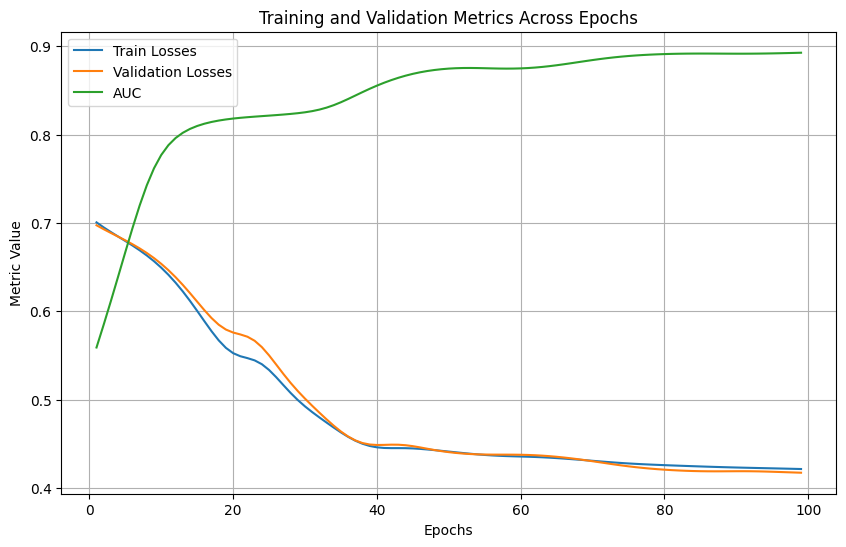

In [58]:
import matplotlib.pyplot as plt
epochs = range(1,100)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Losses')
plt.plot(epochs, val_losses, label='Validation Losses')
plt.plot(epochs, auces, label='AUC')

plt.title('Training and Validation Metrics Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()